In [3]:
# Configuration

# --- Standard Libraries ---
import sys
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
import os
import json
import time
import copy
import cmath
import pickle
import logging
import argparse

# Path configuration (only run once)
sys.path.append(gems_tco_path)

# --- Third-Party Libraries ---
from pathlib import Path
from typing import Optional, List, Tuple, Dict, Any, Callable
from json import JSONEncoder

# Data manipulation and analysis
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import typer

# Torch and Numerical Libraries
import torch
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import matplotlib.pyplot as plt 

# --- Custom (GEMS_TCO) Imports ---
import GEMS_TCO
from GEMS_TCO import kernels_reparam_space_time_gpu
from GEMS_TCO import data_preprocess, data_preprocess as dmbh
from GEMS_TCO import orderings as _orderings 

from GEMS_TCO import alg_optimization
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2
from GEMS_TCO import debiased_whittle


load monthly data

In [4]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2025']
years = ['2024']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 

#lat_range_input=[0,5]      
#lon_range_input=[123, 133] 

df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input

)

In [5]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= ord_mm,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=False  #keep_exact_loc
    )

    daily_aggregated_tensors_vecc.append( day_aggregated_tensor )
    daily_hourly_maps_vecc.append( day_hourly_map )
print(daily_aggregated_tensors_vecc[0].shape)
#print(daily_hourly_maps[0])
nn = daily_aggregated_tensors_vecc[0].shape[0]


# load estimates

base_path_july24 = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/real_dw_vecc_july24_h1000mm16_122525/")

dw_real_july24 = pd.read_csv(base_path_july24 / "real_dw_july24.csv")
vecc_real_july24 = pd.read_csv(base_path_july24 / "real_vecc_july24_h1000_mm16.csv")
dw_real_july24 = dw_real_july24.iloc[:28,4:(4+7)]
vecc_real_july24 = vecc_real_july24.iloc[:28,4:(4+7)]



vecc_real_july24_feat6 = '/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/real_dw_vecc_july24_h1000mm16_011026/real_vecc_cuda_july24_h1000_mm16.csv'
vecc_real_july24_feat6 = pd.read_csv(vecc_real_july24_feat6)
vecc_real_july24_feat6 = vecc_real_july24_feat6.iloc[:28,4:(4+7)]


vecc_real_july24_h300feat6 = '/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/real_dw_vecc_july24_h1000mm16_011026/real_vecc_july24_h300_mm8.csv'
vecc_real_july24_h300feat6 = pd.read_csv(vecc_real_july24_h300feat6)
vecc_real_july24_h300feat6 = vecc_real_july24_h300feat6.iloc[:28,4:(4+7)]


base_path_july25 = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/real_dw_vecc_july25_h1000mm16_122525/")

dw_real_july25 = pd.read_csv(base_path_july25 / "real_dw_july25.csv")
vecc_real_july25 = pd.read_csv(base_path_july25 / "real_vecc_july25_h1000_mm16.csv")
dw_real_july25 = dw_real_july25.iloc[:28,4:(4+7)]
vecc_real_july25 = vecc_real_july25.iloc[:28,4:(4+7)]

torch.Size([145008, 4])


functions setup

whitening 8 multivariate correlation 

x 축 18126*8



# sigma hat profile out

--- Processing Day Index 23 ---
Initializing Debiased Whittle Preprocessor...
Computing Debiased Whittle (Profile Sigma)...
Computing VECC (Profile Sigma)...


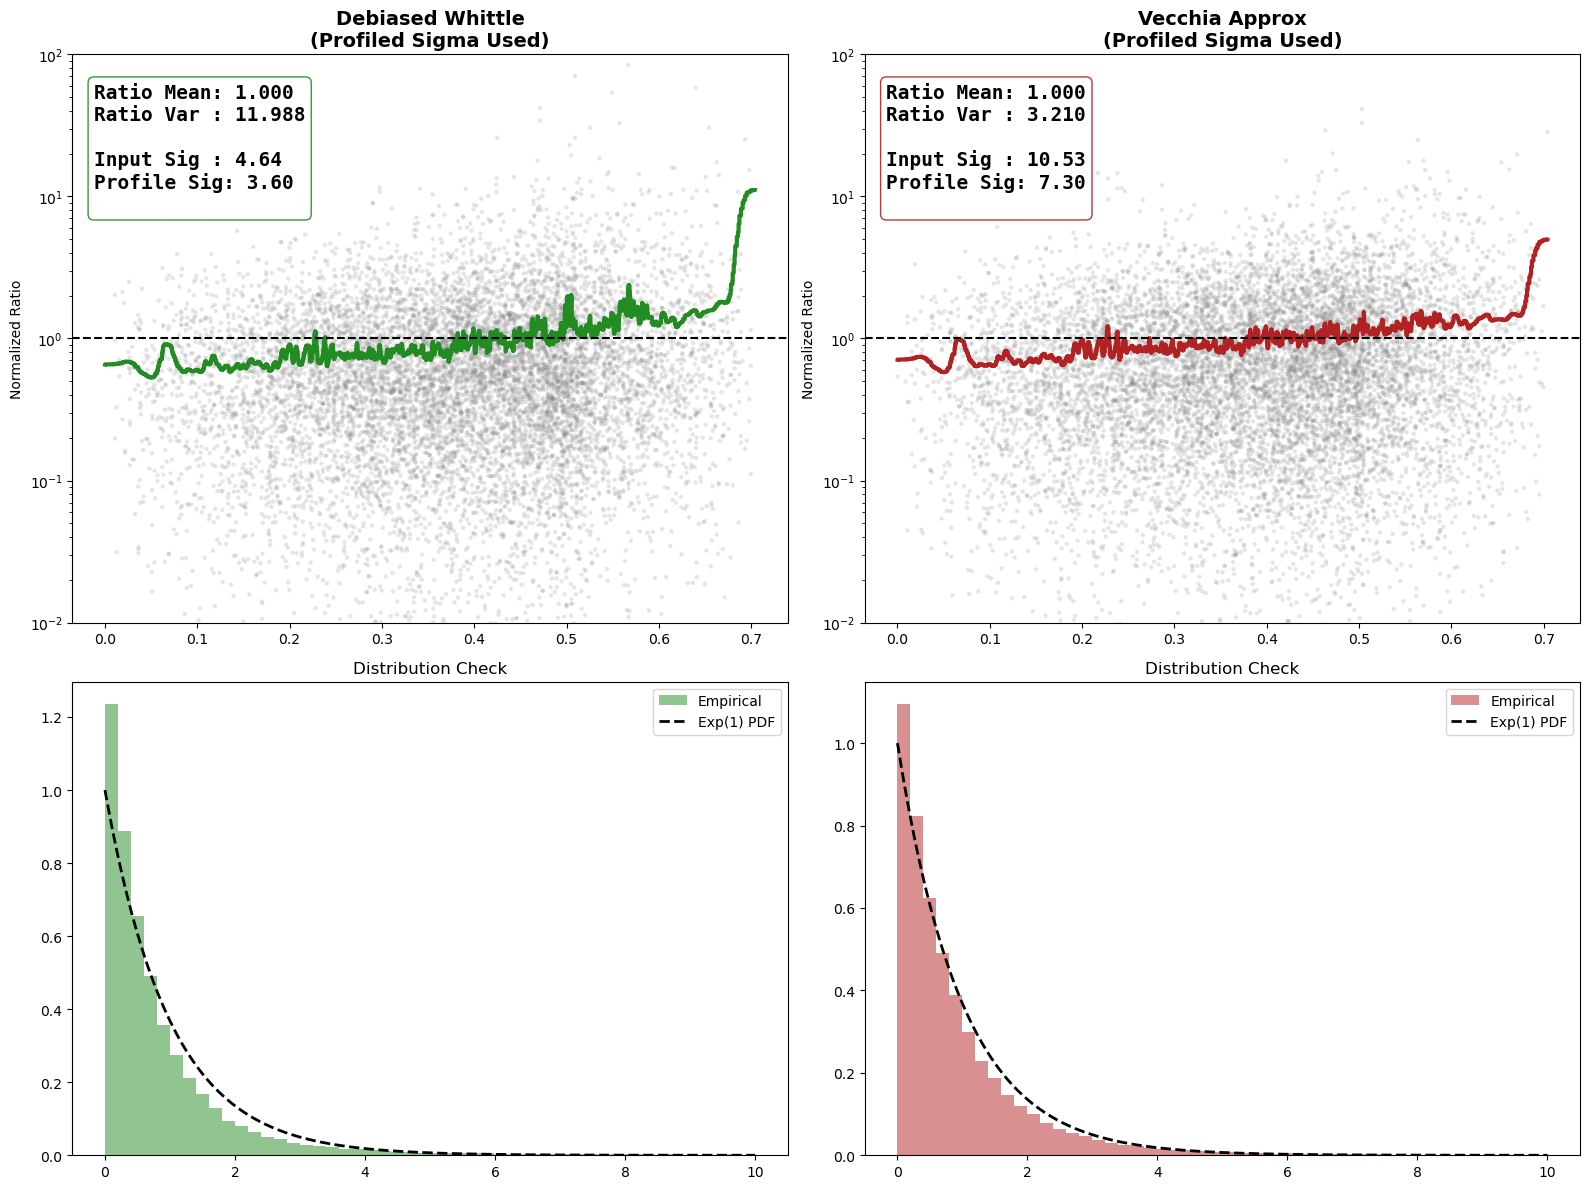

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.ndimage import gaussian_filter1d
import cmath
import sys
import pandas as pd

# (사용자 환경에 맞게 수정)
# from GEMS_TCO import debiased_whittle 

# =========================================================================
# 1. The Logic Class (Debiased Whittle Likelihood Core)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        
        hamming1 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        return autocorr_shifted / (H + 1e-12)

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        p_time = len(tensor_list)
        if p_time == 0: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        valid_tensors = [t for t in tensor_list if t.numel() > 0 and t.shape[1] > max(lat_col, lon_col, val_col)]
        if not valid_tensors: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        all_lats_cpu = torch.cat([t[:, lat_col] for t in valid_tensors]).cpu()
        all_lons_cpu = torch.cat([t[:, lon_col] for t in valid_tensors]).cpu()
        
        mask = ~torch.isnan(all_lats_cpu) & ~torch.isinf(all_lats_cpu) & ~torch.isnan(all_lons_cpu) & ~torch.isinf(all_lons_cpu)
        all_lats_cpu = all_lats_cpu[mask]
        all_lons_cpu = all_lons_cpu[mask]

        unique_lats_cpu, unique_lons_cpu = torch.unique(all_lats_cpu), torch.unique(all_lons_cpu)
        n1, n2 = len(unique_lats_cpu), len(unique_lons_cpu)

        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats_cpu)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons_cpu)}

        u1_mesh_cpu, u2_mesh_cpu = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64),
            torch.arange(n2, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh_cpu, u2_mesh_cpu), n1, n2).to(device)

        fft_results = []
        for tensor in tensor_list:
            data_grid = torch.zeros((n1, n2), dtype=torch.float64, device=device)
            for row in tensor:
                lat_val, lon_val, val = row[lat_col].item(), row[lon_col].item(), row[val_col].item()
                if not (np.isnan(lat_val) or np.isnan(lon_val) or np.isnan(val)):
                    i = lat_map.get(lat_val)
                    j = lon_map.get(lon_val)
                    if i is not None and j is not None:
                        data_grid[i, j] = val

            data_grid_tapered = data_grid * taper_grid 
            data_grid_tapered = torch.nan_to_num(data_grid_tapered, nan=0.0)
            fft_results.append(torch.fft.fft2(data_grid_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)

        return J_vector_tensor * norm_factor, n1, n2, p_time, taper_grid

    @staticmethod
    def calculate_sample_periodogram_vectorized(J_vector_tensor):
        J_col = J_vector_tensor.unsqueeze(-1)
        J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
        return J_col @ J_row_conj

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        device = params.device
        u1 = torch.as_tensor(u1, device=device, dtype=torch.float64)
        u2 = torch.as_tensor(u2, device=device, dtype=torch.float64)
        t  = torch.as_tensor(t, device=device, dtype=torch.float64)

        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        epsilon = 1e-12
        sigmasq = phi1 / (phi2 + epsilon)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + epsilon) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + epsilon) * phi2 

        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t

        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + epsilon)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cov_spatial_difference(u1, u2, t, params, delta1, delta2):
        weights = {(0, 0): -2.0, (1, 0): 1.0, (0, 1): 1.0}
        device = params.device
        cov = torch.zeros_like(u1, device=device, dtype=torch.float64)

        for (a, b), w_ab in weights.items():
            for (c, d), w_cd in weights.items():
                lag_u1 = u1 + (a - c) * delta1
                lag_u2 = u2 + (b - d) * delta2
                cov += w_ab * w_cd * debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(lag_u1, lag_u2, t, params)
        return cov

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        lag_u1 = u1 * delta1
        lag_u2 = u2 * delta2
        cov_val = debiased_whittle_likelihood.cov_spatial_difference(lag_u1, lag_u2, t, params, delta1, delta2)
        
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]
        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        device = params.device
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64, device=device),
            torch.arange(n2, dtype=torch.float64, device=device),
            indexing='ij'
        )
        t_lags = torch.arange(p_time, dtype=torch.float64, device=device)
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        norm_factor = 1.0 / (4.0 * cmath.pi**2)
        return fft_result * norm_factor

# =========================================================================
# 2. Calculation Helper (Profile Sigma - PURE MEAN)
# =========================================================================
def calculate_periodogram_ratio(data_tensor, params_row, device):
    """
    [수정됨] Profile Sigma Calculation (No Robust Masking)
    """
    DELTA_LAT = 0.044 
    DELTA_LON = 0.063
    TAPERING_FUNC = debiased_whittle_likelihood.cgn_hamming 
    
    # 1. Parameter Extraction 
    try:
        sigma_sq = params_row['sigma']
    except KeyError:
        sigma_sq = params_row['sigma_sq']
        
    range_lat = params_row['range_lat']
    range_lon = params_row['range_lon']
    range_time = params_row['range_time']
    advec_lat = params_row['advec_lat']
    advec_lon = params_row['advec_lon']
    nugget = params_row['nugget']
    nugget_safe = nugget if nugget > 1e-9 else 1e-15

    # Phi Parametrization
    phi2 = 1.0 / range_lon
    phi1 = sigma_sq * phi2
    phi3 = (range_lon / range_lat)**2
    phi4 = (range_lon / range_time)**2
    
    params_tensor = torch.tensor([
        np.log(phi1), np.log(phi2), np.log(phi3), np.log(phi4), 
        advec_lat, advec_lon, np.log(nugget_safe)
    ], device=device, dtype=torch.float64)

    # 2. J Vector (Empirical Data FFT)
    cur_df = data_tensor
    unique_times = torch.unique(cur_df[:, 3])
    tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]

    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, TAPERING_FUNC, lat_col=0, lon_col=1, val_col=2, device=device
    )
    
    taper_autocorr_grid = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(
        taper_grid, n1, n2, device
    )

    # 3. Expected Periodogram (Model FFT)
    with torch.no_grad():
        I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
            params_tensor, n1, n2, p_time, taper_autocorr_grid, DELTA_LAT, DELTA_LON
        )

    # 4. Whitening Process
    eye = torch.eye(p_time, device=device, dtype=torch.complex128)
    try:
        L = torch.linalg.cholesky(I_expected + eye * 1e-9) 
    except RuntimeError:
        print("Warning: Cholesky failed, adding more jitter.")
        L = torch.linalg.cholesky(I_expected + eye * 1e-6)

    J_vec_expanded = J_vec.unsqueeze(-1) 
    Z_white = torch.linalg.solve_triangular(L, J_vec_expanded, upper=False)
    
    # Raw Whitened Power (using Input Sigma)
    whitened_power = (Z_white.abs() ** 2).squeeze(-1) # (N1, N2, P)
    ratio_raw = whitened_power.cpu().numpy().flatten()
    
    # -----------------------------------------------------------
    # [핵심 수정] PURE MATH: 모든 데이터를 포함한 평균 계산
    # 아웃라이어(Mask) 제거 로직 완전 삭제
    # -----------------------------------------------------------
    
    # NaN만 안전하게 제외하고(데이터 결함 방지), 값의 크기는 따지지 않음
    scaling_factor = np.nanmean(ratio_raw)
    
    sigma_profile = sigma_sq * scaling_factor
    ratio_normalized = ratio_raw / scaling_factor
    
    # Frequency Axis Mapping
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    freq_lat = fftshift(freq_lat)
    freq_lon = fftshift(freq_lon)
    
    g_lon, g_lat = np.meshgrid(freq_lon, freq_lat, indexing='ij')
    freq_norm = np.sqrt(g_lat**2 + g_lon**2).flatten()
    freq_norm_expanded = np.repeat(freq_norm, p_time)
    
    return freq_norm_expanded, ratio_normalized, sigma_sq, sigma_profile

# =========================================================================
# 3. Main Plotting Function (Comparison Logic Updated)
# =========================================================================
def compare_periodogram_1x2(day_idx, dw_df, vecc_df, raw_tensors, raw_maps):
    print(f"--- Processing Day Index {day_idx} ---")
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # [Step 1] Preprocessing
    print("Initializing Debiased Whittle Preprocessor...")
    from GEMS_TCO import debiased_whittle 
    
    a_dummy = [13.357, 0.1441, 0.1855, 1.1652, 0.0197, -0.1576, 0]
    lat_range = [-3, 2]
    lon_range = [121, 131]
    
    db = debiased_whittle.debiased_whittle_preprocess(
        raw_tensors, raw_maps, day_idx=day_idx, 
        params_list=a_dummy, lat_range=lat_range, lon_range=lon_range
    )
    subsetted_aggregated_day = db.generate_spatially_filtered_days(-3, 2, 121, 131)
    
    if isinstance(subsetted_aggregated_day, np.ndarray):
        data_tensor = torch.from_numpy(subsetted_aggregated_day).to(DEVICE)
    else:
        data_tensor = subsetted_aggregated_day.to(DEVICE)
    
    if data_tensor.shape[0] == 0:
        print("Error: Preprocessed data is empty.")
        return

    # [Step 2] Parameter Extraction & Profile Calculation
    row_dw = dw_df.iloc[day_idx]
    row_vecc = vecc_df.iloc[day_idx]
    
    print("Computing Debiased Whittle (Profile Sigma)...")
    norm_dw, ratio_dw, sig_in_dw, sig_prof_dw = calculate_periodogram_ratio(data_tensor, row_dw, DEVICE)
    
    print("Computing VECC (Profile Sigma)...")
    norm_vecc, ratio_vecc, sig_in_vecc, sig_prof_vecc = calculate_periodogram_ratio(data_tensor, row_vecc, DEVICE)

    # [Step 3] Plotting
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), height_ratios=[1.2, 1])
    ax_scat_dw, ax_scat_vecc = axs[0, 0], axs[0, 1]
    ax_hist_dw, ax_hist_vecc = axs[1, 0], axs[1, 1]
    
    def plot_column(ax_scat, ax_hist, x, y, sig_input, sig_profile, title_prefix, color):
        # 1. Scatter
        # 시각화를 위한 clipping (그래프가 터지지 않게 보기 위해서만 사용)
        y_visual = np.clip(y, 1e-5, 1000.0)
        
        if len(x) > 10000:
            idx = np.random.choice(len(x), 10000, replace=False)
            ax_scat.scatter(x[idx], y_visual[idx], s=10, alpha=0.2, c='gray', edgecolors='none')
        else:
            ax_scat.scatter(x, y_visual, s=10, alpha=0.2, c='gray', edgecolors='none')
            
        if len(x) > 0:
            idx_sort = np.argsort(x)
            trend = gaussian_filter1d(y_visual[idx_sort], sigma=200) 
            ax_scat.plot(x[idx_sort], trend, color=color, linewidth=3, label='Trend')

        ax_scat.axhline(1.0, color='black', linestyle='--', linewidth=1.5)
        
        # -------------------------------------------------------
        # [핵심 수정] 통계치 계산 시 Outlier 제거 로직 삭제
        # 모든 데이터를 사용하여 순수 평균/분산 계산
        # -------------------------------------------------------
        mean_val = np.nanmean(y) # NaNs만 제외
        var_val = np.nanvar(y)
        
        ax_scat.set_yscale('log')
        ax_scat.set_ylim(0.01, 100) 
        ax_scat.set_title(f"{title_prefix}\n(Profiled Sigma Used)", fontsize=14, fontweight='bold')
        ax_scat.set_ylabel(r'Normalized Ratio')
        
        stats_text = (f"Ratio Mean: {mean_val:.3f}\n"
                      f"Ratio Var : {var_val:.3f}\n\n"
                      f"Input Sig : {sig_input:.2f}\n"
                      f"Profile Sig: {sig_profile:.2f}\n"
                        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor=color)
        
        # 폰트 사이즈 14 유지
        ax_scat.text(0.03, 0.95, stats_text, transform=ax_scat.transAxes, 
                    fontsize=14, verticalalignment='top', bbox=props, fontweight='bold', fontfamily='monospace')

        # 2. Histogram
        y_hist = y[y < 10]
        ax_hist.hist(y_hist, bins=50, density=True, color=color, alpha=0.5, label='Empirical')
        xx = np.linspace(0, 10, 200)
        ax_hist.plot(xx, np.exp(-xx), 'k--', linewidth=2, label=r'Exp(1) PDF')
        ax_hist.set_title(f"Distribution Check", fontsize=12)
        ax_hist.legend(loc='upper right')

    plot_column(ax_scat_dw, ax_hist_dw, norm_dw, ratio_dw, sig_in_dw, sig_prof_dw, "Debiased Whittle", "forestgreen")
    plot_column(ax_scat_vecc, ax_hist_vecc, norm_vecc, ratio_vecc, sig_in_vecc, sig_prof_vecc, "Vecchia Approx", "firebrick")
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    compare_periodogram_1x2(
        day_idx=23, 
        dw_df=dw_real_july25,
        vecc_df=vecc_real_july25,
        raw_tensors=daily_aggregated_tensors_dw, 
        raw_maps=daily_hourly_maps_dw
    )

In [16]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

# =========================================================================
# Analysis Loop (Updated: Pure Mean/Var without Robust Masking)
# =========================================================================
def analyze_all_days(dw_df, vecc_df, raw_tensors, raw_maps, start_day=0, end_day=28):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    from GEMS_TCO import debiased_whittle # 전처리용
    
    results = []
    
    print(f"Starting Analysis Loop: Day {start_day} to {end_day}")
    
    for day_idx in tqdm(range(start_day, end_day + 1)):
        # ---------------------------------------------------
        # 1. Preprocess Data
        # ---------------------------------------------------
        try:
            db = debiased_whittle.debiased_whittle_preprocess(
                raw_tensors, raw_maps, day_idx=day_idx, 
                params_list=[13.3, 0.14, 0.18, 1.16, 0.02, -0.15, 0], 
                lat_range=[-3, 2], lon_range=[121, 131]
            )
            subset = db.generate_spatially_filtered_days(-3, 2, 121, 131)
            
            if isinstance(subset, np.ndarray): data_tensor = torch.from_numpy(subset).to(DEVICE)
            else: data_tensor = subset.to(DEVICE)
            
            if data_tensor.shape[0] == 0:
                results.append({'Day': day_idx, 'DW_Mean': np.nan, 'DW_Var': np.nan, 'Vecc_Mean': np.nan, 'Vecc_Var': np.nan})
                continue
                
        except Exception as e:
            print(f"Error prepping Day {day_idx}: {e}")
            results.append({'Day': day_idx, 'DW_Mean': np.nan, 'DW_Var': np.nan, 'Vecc_Mean': np.nan, 'Vecc_Var': np.nan})
            continue

        # -----------------------------------------------------------
        # Helper to unpack return values safely
        # -----------------------------------------------------------
        def get_ratio_safe(tensor, params):
            # 함수가 (freq, ratio, sigma, profile)을 반환하는지, ratio만 반환하는지 확인
            ret = calculate_periodogram_ratio(tensor, params, DEVICE)
            if isinstance(ret, tuple):
                return ret[1]  # 2번째 요소가 normalized ratio
            return ret

        # ---------------------------------------------------
        # 2. Get Statistics (DW)
        # ---------------------------------------------------
        try:
            row_dw = dw_df.iloc[day_idx]
            ratio_dw = get_ratio_safe(data_tensor, row_dw)
            
            # [수정됨] Robust Masking (< 50.0) 제거 -> Pure Stats 계산
            dw_mean = np.nanmean(ratio_dw)
            dw_var = np.nanvar(ratio_dw)

        except Exception as e:
            print(f"Error calc DW Day {day_idx}: {e}")
            dw_mean, dw_var = np.nan, np.nan

        # ---------------------------------------------------
        # 3. Get Statistics (Vecchia)
        # ---------------------------------------------------
        try:
            row_vecc = vecc_df.iloc[day_idx]
            ratio_vecc = get_ratio_safe(data_tensor, row_vecc)
            
            # [수정됨] Robust Masking (< 50.0) 제거 -> Pure Stats 계산
            vecc_mean = np.nanmean(ratio_vecc)
            vecc_var = np.nanvar(ratio_vecc)

        except Exception as e:
            print(f"Error calc Vecc Day {day_idx}: {e}")
            vecc_mean, vecc_var = np.nan, np.nan
            
        # ---------------------------------------------------
        # 4. Append Result
        # ---------------------------------------------------
        results.append({
            'Day': day_idx,
            'DW_Mean': dw_mean,
            'DW_Var': dw_var,
            'Vecc_Mean': vecc_mean,
            'Vecc_Var': vecc_var
        })
    
    # Create DataFrame
    result_df = pd.DataFrame(results)
    result_df = result_df[['Day', 'DW_Mean', 'DW_Var', 'Vecc_Mean', 'Vecc_Var']]
    return result_df

# =========================================================================
# Execution
# =========================================================================
if __name__ == '__main__':
    # 실행
    df_results = analyze_all_days(
        dw_df=dw_real_july24,
        vecc_df=vecc_real_july24_feat6,
        raw_tensors=daily_aggregated_tensors_dw, 
        raw_maps=daily_hourly_maps_dw,
        start_day=0, 
        end_day=28
    )
    
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\n=== Final Analysis Results (Pure Profiled Stats) ===")
    print(df_results)
    
    print("\n=== Overall Average ===")
    print(df_results.mean(numeric_only=True))

Starting Analysis Loop: Day 0 to 28


100%|██████████| 29/29 [01:03<00:00,  2.18s/it]

Error calc DW Day 28: single positional indexer is out-of-bounds
Error calc Vecc Day 28: single positional indexer is out-of-bounds

=== Final Analysis Results (Pure Profiled Stats) ===
    Day  DW_Mean  DW_Var  Vecc_Mean  Vecc_Var
0     0   1.0000  1.5935     1.0000    1.4136
1     1   1.0000  1.3203     1.0000    1.3269
2     2   1.0000  1.2418     1.0000    1.1982
3     3   1.0000  1.2075     1.0000    1.1889
4     4   1.0000  1.2521     1.0000    1.2207
5     5   1.0000  1.3122     1.0000    1.3050
6     6   1.0000  1.2270     1.0000    1.2756
7     7   1.0000  1.3608     1.0000    1.3504
8     8   1.0000  1.5046     1.0000    1.4950
9     9   1.0000  1.8927     1.0000    2.0887
10   10   1.0000  1.5256     1.0000    1.4997
11   11   1.0000  1.3947     1.0000    1.3309
12   12   1.0000  2.0101     1.0000    1.7467
13   13   1.0000  1.9013     1.0000    1.5634
14   14   1.0000  1.5814     1.0000    1.3590
15   15   1.0000  1.4484     1.0000    1.3477
16   16   1.0000  2.8441     1.0

In [26]:
if __name__ == '__main__':
    # 실행
    df_results = analyze_all_days(
        dw_df=dw_real_july25,
        vecc_df=vecc_real_july25,
        raw_tensors=daily_aggregated_tensors_dw, 
        raw_maps=daily_hourly_maps_dw,
        start_day=0, 
        end_day=28
    )
    
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\n=== Final Analysis Results (Profiled Sigma Applied) ===")
    print(df_results)
    
    print("\n=== Overall Average ===")
    print(df_results.mean(numeric_only=True))

Starting Analysis Loop: Day 0 to 28


100%|██████████| 29/29 [01:04<00:00,  2.22s/it]

Error calc DW Day 28: single positional indexer is out-of-bounds
Error calc Vecc Day 28: single positional indexer is out-of-bounds

=== Final Analysis Results (Profiled Sigma Applied) ===
    Day  DW_Mean  DW_Var  Vecc_Mean  Vecc_Var
0     0   1.0000  2.7174     1.0000    1.5539
1     1   1.0000  1.4276     1.0000    1.3123
2     2   1.0000  1.2642     1.0000    1.2573
3     3   1.0000  1.3435     1.0000    1.2001
4     4   1.0000  1.2332     1.0000    1.2186
5     5   1.0000  1.3069     1.0000    1.3146
6     6   1.0000  1.3428     1.0000    1.2796
7     7   1.0000  1.5091     1.0000    1.5894
8     8   1.0000  1.4145     1.0000    1.3991
9     9   1.0000  2.1470     1.0000    1.9311
10   10   1.0000  2.4983     1.0000    1.5567
11   11   1.0000  1.4378     1.0000    1.3474
12   12   1.0000  2.8960     1.0000    1.6304
13   13   1.0000  1.4677     1.0000    1.4680
14   14   1.0000  1.5214     1.0000    1.3506
15   15   1.0000  1.4708     1.0000    1.4065
16   16   1.0000  1.5775     

In [29]:
dw_real_july25

,sigma,range_lat,range_lon,range_time,advec_lat,advec_lon,nugget
0,7.5965,0.1309,0.1462,0.7241,0.0160,-0.1058,0.0000
1,6.6543,0.1397,0.1687,0.8297,0.0053,-0.1433,0.0000
2,8.6710,0.1302,0.1367,0.8378,0.0025,-0.2718,0.0000
3,8.6597,0.1051,0.1079,0.9007,-0.0000,-0.0000,0.0000
4,19.5931,0.1763,0.1853,1.5004,-0.0159,-0.4003,0.0000
5,17.0221,0.1775,0.2002,1.1096,0.0556,-0.3840,0.0000
6,11.8850,0.2576,0.2923,1.2670,0.0191,-0.2946,0.0000
7,12.0310,0.1269,0.1523,0.7945,-0.0023,-0.3988,0.0000
8,8.0513,0.1682,0.2131,0.7852,0.0000,-0.0000,0.0000
9,13.9103,0.1363,0.1827,0.5733,0.0000,-0.0000,0.3319


시그마 못구하자나 노멀라이즈 해보자 그러고 나머지 구조를 보자 

--- Processing Day Index 0 ---
Initializing Debiased Whittle Preprocessor...
Data Prepared. Shape: torch.Size([142832, 4])
Computing Debiased Whittle Diagnostics (Whitening + Norm)...
Computing VECC Diagnostics (Whitening + Norm)...


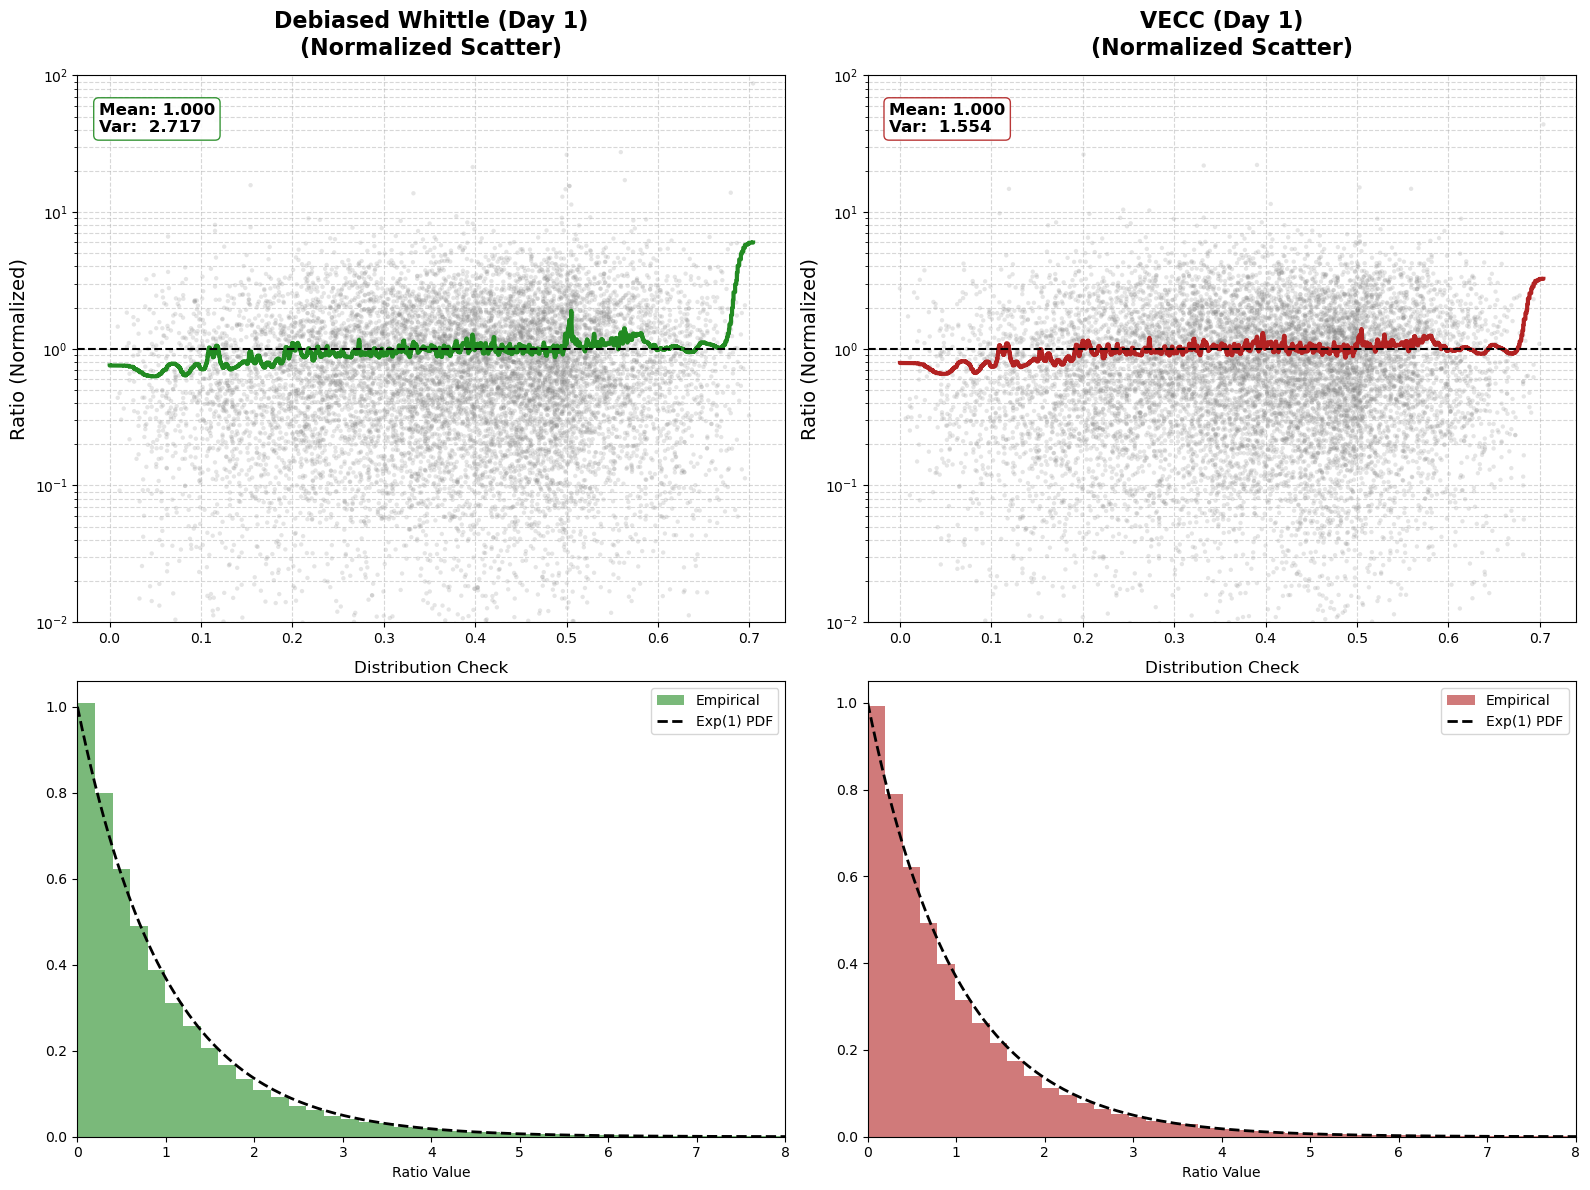

In [132]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.ndimage import gaussian_filter1d
import cmath
import sys
import pandas as pd

# (사용자 환경에 맞게 수정: 라이브러리가 없다면 주석 처리 후 더미 데이터 사용)
# from GEMS_TCO import debiased_whittle 

# =========================================================================
# 1. The Logic Class (Debiased Whittle Likelihood Core)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        
        # [Corrected Hamming] Minus sign for Bell shape
        hamming1 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        return autocorr_shifted / (H + 1e-12)

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        p_time = len(tensor_list)
        if p_time == 0: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        valid_tensors = [t for t in tensor_list if t.numel() > 0 and t.shape[1] > max(lat_col, lon_col, val_col)]
        if not valid_tensors: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        all_lats_cpu = torch.cat([t[:, lat_col] for t in valid_tensors]).cpu()
        all_lons_cpu = torch.cat([t[:, lon_col] for t in valid_tensors]).cpu()
        
        mask = ~torch.isnan(all_lats_cpu) & ~torch.isinf(all_lats_cpu) & ~torch.isnan(all_lons_cpu) & ~torch.isinf(all_lons_cpu)
        all_lats_cpu = all_lats_cpu[mask]
        all_lons_cpu = all_lons_cpu[mask]

        unique_lats_cpu, unique_lons_cpu = torch.unique(all_lats_cpu), torch.unique(all_lons_cpu)
        n1, n2 = len(unique_lats_cpu), len(unique_lons_cpu)

        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats_cpu)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons_cpu)}

        u1_mesh_cpu, u2_mesh_cpu = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64),
            torch.arange(n2, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh_cpu, u2_mesh_cpu), n1, n2).to(device)

        fft_results = []
        for tensor in tensor_list:
            data_grid = torch.zeros((n1, n2), dtype=torch.float64, device=device)
            for row in tensor:
                lat_val, lon_val, val = row[lat_col].item(), row[lon_col].item(), row[val_col].item()
                if not (np.isnan(lat_val) or np.isnan(lon_val) or np.isnan(val)):
                    i = lat_map.get(lat_val)
                    j = lon_map.get(lon_val)
                    if i is not None and j is not None:
                        data_grid[i, j] = val

            data_grid_tapered = data_grid * taper_grid 
            data_grid_tapered = torch.nan_to_num(data_grid_tapered, nan=0.0)
            fft_results.append(torch.fft.fft2(data_grid_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)

        return J_vector_tensor * norm_factor, n1, n2, p_time, taper_grid

    @staticmethod
    def calculate_sample_periodogram_vectorized(J_vector_tensor):
        J_col = J_vector_tensor.unsqueeze(-1)
        J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
        return J_col @ J_row_conj

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        device = params.device
        u1 = torch.as_tensor(u1, device=device, dtype=torch.float64)
        u2 = torch.as_tensor(u2, device=device, dtype=torch.float64)
        t  = torch.as_tensor(t, device=device, dtype=torch.float64)

        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        epsilon = 1e-12
        sigmasq = phi1 / (phi2 + epsilon)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + epsilon) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + epsilon) * phi2 

        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t

        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + epsilon)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cov_spatial_difference(u1, u2, t, params, delta1, delta2):
        weights = {(0, 0): -2.0, (1, 0): 1.0, (0, 1): 1.0}
        device = params.device
        cov = torch.zeros_like(u1, device=device, dtype=torch.float64)

        for (a, b), w_ab in weights.items():
            for (c, d), w_cd in weights.items():
                lag_u1 = u1 + (a - c) * delta1
                lag_u2 = u2 + (b - d) * delta2
                cov += w_ab * w_cd * debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(lag_u1, lag_u2, t, params)
        return cov

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        lag_u1 = u1 * delta1
        lag_u2 = u2 * delta2
        cov_val = debiased_whittle_likelihood.cov_spatial_difference(lag_u1, lag_u2, t, params, delta1, delta2)
        
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]
        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        device = params.device
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64, device=device),
            torch.arange(n2, dtype=torch.float64, device=device),
            indexing='ij'
        )
        t_lags = torch.arange(p_time, dtype=torch.float64, device=device)
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        norm_factor = 1.0 / (4.0 * cmath.pi**2)
        return fft_result * norm_factor

# =========================================================================
# 2. Calculation Helper (Whitening + Forced Normalization)
# =========================================================================
def calculate_periodogram_ratio(data_tensor, params_row, device):
    """
    [Normalization 적용] Whitening 후, 평균을 강제로 1.0으로 만듦.
    -> Scale Mismatch를 제거하고 Structure Mismatch(Variance)만 보기 위함.
    """
    DELTA_LAT = 0.044 
    DELTA_LON = 0.063
    TAPERING_FUNC = debiased_whittle_likelihood.cgn_hamming 
    
    # --- Parameter Extraction ---
    try:
        sigma_sq = params_row['sigma']
    except KeyError:
        sigma_sq = params_row['sigma_sq']
        
    range_lat = params_row['range_lat']
    range_lon = params_row['range_lon']
    range_time = params_row['range_time']
    advec_lat = params_row['advec_lat']
    advec_lon = params_row['advec_lon']
    nugget = params_row['nugget']
    nugget_safe = nugget if nugget > 1e-9 else 1e-12

    phi2 = 1.0 / range_lon
    phi1 = sigma_sq * phi2
    phi3 = (range_lon / range_lat)**2
    phi4 = (range_lon / range_time)**2
    
    params_tensor = torch.tensor([
        np.log(phi1), np.log(phi2), np.log(phi3), np.log(phi4), 
        advec_lat, advec_lon, np.log(nugget_safe)
    ], device=device, dtype=torch.float64)

    cur_df = data_tensor
    unique_times = torch.unique(cur_df[:, 3])
    tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]

    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, TAPERING_FUNC, lat_col=0, lon_col=1, val_col=2, device=device
    )
    
    taper_autocorr_grid = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(
        taper_grid, n1, n2, device
    )

    with torch.no_grad():
        I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
            params_tensor, n1, n2, p_time, taper_autocorr_grid, DELTA_LAT, DELTA_LON
        )

    # --- Whitening Process (Cholesky) ---
    eye = torch.eye(p_time, device=device, dtype=torch.complex128)
    try:
        L = torch.linalg.cholesky(I_expected + eye * 1e-9) 
    except RuntimeError:
        print("Warning: Cholesky failed, adding more jitter.")
        L = torch.linalg.cholesky(I_expected + eye * 1e-6)

    J_vec_expanded = J_vec.unsqueeze(-1) 
    Z_white = torch.linalg.solve_triangular(L, J_vec_expanded, upper=False)
    
    # |Z|^2 Calculation
    whitened_power = (Z_white.abs() ** 2).squeeze(-1) # (N1, N2, P)
    
    # ----------------------------------------------------------------------
    # [핵심] Profile Likelihood Assumption (Forced Normalization)
    # 전체 평균을 구해서 나눠버림 -> 결과 평균은 무조건 1.0이 됨
    # ----------------------------------------------------------------------
    global_mean = torch.mean(whitened_power)
    whitened_power_norm = whitened_power / global_mean
    
    ratio_flat = whitened_power_norm.cpu().numpy().flatten()
    
    # Frequency Axis Mapping
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    freq_lat = fftshift(freq_lat)
    freq_lon = fftshift(freq_lon)
    
    g_lon, g_lat = np.meshgrid(freq_lon, freq_lat, indexing='ij')
    freq_norm = np.sqrt(g_lat**2 + g_lon**2).flatten()
    freq_norm_expanded = np.repeat(freq_norm, p_time)
    
    return freq_norm_expanded, ratio_flat


# =========================================================================
# 3. Main Plotting Function
# =========================================================================
def compare_periodogram_1x2(day_idx, dw_df, vecc_df, raw_tensors, raw_maps):
    print(f"--- Processing Day Index {day_idx} ---")
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # -------------------------------------------------------
    # [Step 1] Preprocessing
    # -------------------------------------------------------
    print("Initializing Debiased Whittle Preprocessor...")
    
    from GEMS_TCO import debiased_whittle 
    
    a_dummy = [13.357, 0.1441, 0.1855, 1.1652, 0.0197, -0.1576, 0]
    lat_range = [-3, 2]
    lon_range = [121, 131]
    
    db = debiased_whittle.debiased_whittle_preprocess(
        raw_tensors, raw_maps, day_idx=day_idx, 
        params_list=a_dummy, lat_range=lat_range, lon_range=lon_range
    )

    subsetted_aggregated_day = db.generate_spatially_filtered_days(-3, 2, 121, 131)
    
    if isinstance(subsetted_aggregated_day, np.ndarray):
        data_tensor = torch.from_numpy(subsetted_aggregated_day).to(DEVICE)
    else:
        data_tensor = subsetted_aggregated_day.to(DEVICE)
        
    print(f"Data Prepared. Shape: {data_tensor.shape}")
    
    if data_tensor.shape[0] == 0:
        print("Error: Preprocessed data is empty.")
        return

    # -------------------------------------------------------
    # [Step 2] Parameter Extraction & Whitening Calculation
    # -------------------------------------------------------
    row_dw = dw_df.iloc[day_idx]
    row_vecc = vecc_df.iloc[day_idx]
    
    print("Computing Debiased Whittle Diagnostics (Whitening + Norm)...")
    norm_dw, ratio_dw = calculate_periodogram_ratio(data_tensor, row_dw, DEVICE)
    
    print("Computing VECC Diagnostics (Whitening + Norm)...")
    norm_vecc, ratio_vecc = calculate_periodogram_ratio(data_tensor, row_vecc, DEVICE)

    # -------------------------------------------------------
    # [Step 3] Plotting
    # -------------------------------------------------------
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), height_ratios=[1.2, 1])
    
    # GridSpec Layout
    ax_scat_dw = axs[0, 0]
    ax_scat_vecc = axs[0, 1]
    ax_hist_dw = axs[1, 0]
    ax_hist_vecc = axs[1, 1]
    
    def plot_column(ax_scat, ax_hist, x, y, title_prefix, color):
        # 1. Scatter Plot
        # 시각화용 Clipping (너무 큰 값은 잘라서 보여줌)
        y_visual = np.clip(y, 1e-5, 100.0)
        
        if len(x) > 10000:
            idx = np.random.choice(len(x), 10000, replace=False)
            ax_scat.scatter(x[idx], y_visual[idx], s=10, alpha=0.2, c='gray', edgecolors='none')
        else:
            ax_scat.scatter(x, y_visual, s=10, alpha=0.2, c='gray', edgecolors='none')
            
        # Trend Line
        if len(x) > 0:
            idx_sort = np.argsort(x)
            trend = gaussian_filter1d(y_visual[idx_sort], sigma=200) 
            ax_scat.plot(x[idx_sort], trend, color=color, linewidth=3, label='Trend')

        # Reference Line (Target = 1.0)
        ax_scat.axhline(1.0, color='black', linestyle='--', linewidth=1.5)
        
        # [Stats Calculation] 
        # 이미 Normalization을 했으므로, 전체 Mean은 1.0입니다.
        # 하지만 통계 박스에는 'Robust Mean'을 보여주기 위해 아웃라이어 제외 계산
        # (전체 Mean이 1.0임을 보여주고 싶으면 y_clean 대신 y를 쓰면 됨)
        
        mean_val = np.mean(y) # Normalization 확인용 (무조건 1.0 근처여야 함)
        var_val = np.var(y)   # 전체 분산
        
        # Formatting
        ax_scat.set_yscale('log')
        ax_scat.set_ylim(0.01, 100) 
        ax_scat.set_title(f"{title_prefix}\n(Normalized Scatter)", fontsize=16, fontweight='bold', pad=15)
        ax_scat.set_ylabel(r'Ratio (Normalized)', fontsize=14)
        ax_scat.grid(True, which="both", ls="--", alpha=0.5)
        
        # Stats Box
        stats_text = (f"Mean: {mean_val:.3f}\n"
                      f"Var:  {var_val:.3f}")
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor=color)
        ax_scat.text(0.03, 0.95, stats_text, transform=ax_scat.transAxes, 
                    fontsize=12, verticalalignment='top', bbox=props, fontweight='bold')

        # 2. Histogram
        y_hist = y[y < 10] 
        ax_hist.hist(y_hist, bins=50, density=True, color=color, alpha=0.6, label='Empirical')
        
        xx = np.linspace(0, 10, 200)
        ax_hist.plot(xx, np.exp(-xx), 'k--', linewidth=2, label=r'Exp(1) PDF')
        
        ax_hist.set_title(f"Distribution Check", fontsize=12)
        ax_hist.set_xlabel('Ratio Value')
        ax_hist.set_xlim(0, 8) 
        ax_hist.legend(loc='upper right')

    # Define colors
    color_dw = 'forestgreen'
    color_vecc = 'firebrick'

    # Plot Columns
    plot_column(ax_scat_dw, ax_hist_dw, norm_dw, ratio_dw, f"Debiased Whittle (Day {day_idx+1})", color_dw)
    plot_column(ax_scat_vecc, ax_hist_vecc, norm_vecc, ratio_vecc, f"VECC (Day {day_idx+1})", color_vecc)

    plt.tight_layout()
    plt.show()

# =========================================================================
# Execution
# =========================================================================
if __name__ == '__main__':
    # 아래 함수를 실행하세요.
    compare_periodogram_1x2(
        day_idx=0,  # 0 based index
        dw_df=dw_real_july25,
        #dw_df=vecc_real_july24_feat6,
        vecc_df=vecc_real_july25,
        raw_tensors=daily_aggregated_tensors_dw, 
        raw_maps=daily_hourly_maps_dw
    )

시간축 평균 내버림

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.ndimage import gaussian_filter1d
import cmath
import sys
import pandas as pd



# =========================================================================
# 1. The Logic Class (Debiased Whittle Likelihood Core)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        """Computes a 2D Hamming window."""
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        hamming1 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        """Computes the normalized taper autocorrelation function c_gn(u) using FFT."""
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        c_gn_grid = autocorr_shifted / (H + 1e-12)
        return c_gn_grid 

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        """Generates J-vector and returns necessary metadata."""
        p_time = len(tensor_list)
        if p_time == 0: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        # Filter valid tensors
        valid_tensors = [t for t in tensor_list if t.numel() > 0 and t.shape[1] > max(lat_col, lon_col, val_col)]
        if not valid_tensors: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        # Get Coordinates
        all_lats_cpu = torch.cat([t[:, lat_col] for t in valid_tensors]).cpu()
        all_lons_cpu = torch.cat([t[:, lon_col] for t in valid_tensors]).cpu()
        
        # Simple Nan Filter
        mask = ~torch.isnan(all_lats_cpu) & ~torch.isinf(all_lats_cpu) & ~torch.isnan(all_lons_cpu) & ~torch.isinf(all_lons_cpu)
        all_lats_cpu = all_lats_cpu[mask]
        all_lons_cpu = all_lons_cpu[mask]

        unique_lats_cpu, unique_lons_cpu = torch.unique(all_lats_cpu), torch.unique(all_lons_cpu)
        n1, n2 = len(unique_lats_cpu), len(unique_lons_cpu)

        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats_cpu)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons_cpu)}

        # Generate Taper
        u1_mesh_cpu, u2_mesh_cpu = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64),
            torch.arange(n2, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh_cpu, u2_mesh_cpu), n1, n2).to(device)

        # Fill Data Grid
        fft_results = []
        for tensor in tensor_list:
            data_grid = torch.zeros((n1, n2), dtype=torch.float64, device=device)
            # data filling loop
            for row in tensor:
                lat_val, lon_val, val = row[lat_col].item(), row[lon_col].item(), row[val_col].item()
                if not (np.isnan(lat_val) or np.isnan(lon_val) or np.isnan(val)):
                    i = lat_map.get(lat_val)
                    j = lon_map.get(lon_val)
                    if i is not None and j is not None:
                        data_grid[i, j] = val

            data_grid_tapered = data_grid * taper_grid 
            data_grid_tapered = torch.nan_to_num(data_grid_tapered, nan=0.0)
            fft_results.append(torch.fft.fft2(data_grid_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)

        return J_vector_tensor * norm_factor, n1, n2, p_time, taper_grid

    @staticmethod
    def calculate_sample_periodogram_vectorized(J_vector_tensor):
        """Calculates sample periodogram I_n = J J^H."""
        J_col = J_vector_tensor.unsqueeze(-1)
        J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
        return J_col @ J_row_conj

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        """7-Parameter Spatio-Temporal Kernel (Exponential/Matern 0.5)."""
        device = params.device
        u1 = torch.as_tensor(u1, device=device, dtype=torch.float64)
        u2 = torch.as_tensor(u2, device=device, dtype=torch.float64)
        t  = torch.as_tensor(t, device=device, dtype=torch.float64)

        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        epsilon = 1e-12
        sigmasq = phi1 / (phi2 + epsilon)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + epsilon) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + epsilon) * phi2 

        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t

        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + epsilon)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cov_spatial_difference(u1, u2, t, params, delta1, delta2):
        weights = {(0, 0): -2.0, (1, 0): 1.0, (0, 1): 1.0}
        device = params.device
        cov = torch.zeros_like(u1, device=device, dtype=torch.float64)

        for (a, b), w_ab in weights.items():
            for (c, d), w_cd in weights.items():
                lag_u1 = u1 + (a - c) * delta1
                lag_u2 = u2 + (b - d) * delta2
                cov += w_ab * w_cd * debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(lag_u1, lag_u2, t, params)
        return cov

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        lag_u1 = u1 * delta1
        lag_u2 = u2 * delta2
        cov_val = debiased_whittle_likelihood.cov_spatial_difference(lag_u1, lag_u2, t, params, delta1, delta2)
        
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]
        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        """Calculates expected periodogram using Aliasing Sum (Lemma 2)."""
        device = params.device
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64, device=device),
            torch.arange(n2, dtype=torch.float64, device=device),
            indexing='ij'
        )
        t_lags = torch.arange(p_time, dtype=torch.float64, device=device)
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        norm_factor = 1.0 / (4.0 * cmath.pi**2)
        return fft_result * norm_factor

# =========================================================================
# 1. Calculation Helper (수학 계산용)
# =========================================================================
def calculate_periodogram_ratio(data_tensor, params_row, device):
    DELTA_LAT = 0.044 
    DELTA_LON = 0.063
    TAPERING_FUNC = debiased_whittle_likelihood.cgn_hamming 
    
    # 파라미터 추출 (동일)
    try:
        sigma_sq = params_row['sigma']
    except KeyError:
        sigma_sq = params_row['sigma_sq']
        
    range_lat = params_row['range_lat']
    range_lon = params_row['range_lon']
    range_time = params_row['range_time']
    advec_lat = params_row['advec_lat']
    advec_lon = params_row['advec_lon']
    nugget = params_row['nugget']
    nugget_safe = nugget if nugget > 1e-9 else 1e-12

    phi2 = 1.0 / range_lon
    phi1 = sigma_sq * phi2
    phi3 = (range_lon / range_lat)**2
    phi4 = (range_lon / range_time)**2
    
    params_tensor = torch.tensor([
        np.log(phi1), np.log(phi2), np.log(phi3), np.log(phi4), 
        advec_lat, advec_lon, np.log(nugget_safe)
    ], device=device, dtype=torch.float64)

    cur_df = data_tensor
    unique_times = torch.unique(cur_df[:, 3])
    tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]

    # J Vector (N1, N2, P)
    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, TAPERING_FUNC, lat_col=0, lon_col=1, val_col=2, device=device
    )
    
    taper_autocorr_grid = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(
        taper_grid, n1, n2, device
    )

    # Expected Periodogram Matrix (N1, N2, P, P)
    with torch.no_grad():
        I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
            params_tensor, n1, n2, p_time, taper_autocorr_grid, DELTA_LAT, DELTA_LON
        )

    # -------------------------------------------------------------------
    # [핵심 변경] Whitening Process for Temporal Correlation Check
    # -------------------------------------------------------------------
    # 1. Cholesky Decomposition: I_exp = L * L^H
    eye = torch.eye(p_time, device=device, dtype=torch.complex128)
    # 수치 안정성을 위해 아주 작은 값 더함
    L = torch.linalg.cholesky(I_expected + eye * 1e-9) 
    
    # 2. Whitening: Z = L^{-1} * J
    # J_vec (N1, N2, P) -> (N1, N2, P, 1)
    J_vec_expanded = J_vec.unsqueeze(-1)
    Z_white = torch.linalg.solve_triangular(L, J_vec_expanded, upper=False)
    
    # 3. Whitened Power: |Z|^2
    # 이론적으로 모델이 맞다면, 시간 상관성이 제거된 이 값은 Exp(1)을 따름
    # 평균은 1.0 이어야 함.
    whitened_power = (Z_white.abs() ** 2).squeeze(-1) # (N1, N2, P)
    
    # 4. Flattening & Frequency Mapping
    # 시간축(P)을 평균내지 않고 모두 펼쳐서 보여줌 (엄밀한 검증)
    ratio_flat = whitened_power.cpu().numpy().flatten()
    
    # Frequency Axis (Repeat P times to match flattened ratio)
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    # FFT Shift가 필요 없음 (Whitening은 순서 상관 X, freq만 매칭하면 됨)
    # 하지만 시각화를 위해 fftshift 적용된 freq map 사용
    freq_lat = fftshift(freq_lat)
    freq_lon = fftshift(freq_lon)
    
    g_lon, g_lat = np.meshgrid(freq_lon, freq_lat, indexing='ij')
    freq_norm = np.sqrt(g_lat**2 + g_lon**2).flatten()
    
    # (N1*N2) 개수만큼 P번 반복
    freq_norm_expanded = np.repeat(freq_norm, p_time)
    
    return freq_norm_expanded, ratio_flat

# =========================================================================
# 2. Main Plotting Function (전처리 클래스 사용)
# =========================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.ndimage import gaussian_filter1d
from GEMS_TCO import debiased_whittle  # 전처리용 모듈

# ... (앞부분 debiased_whittle_likelihood 클래스 및 calculate_periodogram_ratio 함수는 위와 동일하게 유지) ...
# ... (꼭 위에서 제가 드린 'Whitening 버전'의 calculate_periodogram_ratio를 사용하셔야 합니다!) ...

# =========================================================================
# 2. Main Plotting Function (Updated)
# =========================================================================
def compare_periodogram_diagnostics(day_idx, dw_df, vecc_df, raw_tensors, raw_maps):
    print(f"--- Processing Day Index {day_idx} ---")
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # -------------------------------------------------------
    # [Step 1] Preprocessing
    # -------------------------------------------------------
    print("Initializing Debiased Whittle Preprocessor...")
    
    a_dummy = [13.357, 0.1441, 0.1855, 1.1652, 0.0197, -0.1576, 0]
    lat_range = [-3, 2]
    lon_range = [121, 131]
    
    db = debiased_whittle.debiased_whittle_preprocess(
        raw_tensors, raw_maps, day_idx=day_idx, 
        params_list=a_dummy, lat_range=lat_range, lon_range=lon_range
    )

    subsetted_aggregated_day = db.generate_spatially_filtered_days(-3, 2, 121, 131)
    
    if isinstance(subsetted_aggregated_day, np.ndarray):
        data_tensor = torch.from_numpy(subsetted_aggregated_day).to(DEVICE)
    else:
        data_tensor = subsetted_aggregated_day.to(DEVICE)
        
    print(f"Data Prepared. Shape: {data_tensor.shape}")
    
    if data_tensor.shape[0] == 0:
        print("Error: Preprocessed data is empty.")
        return

    # -------------------------------------------------------
    # [Step 2] Parameter Extraction & Whitening Calculation
    # -------------------------------------------------------
    row_dw = dw_df.iloc[day_idx]
    row_vecc = vecc_df.iloc[day_idx]
    
    print("Computing Debiased Whittle Diagnostics (Whitened)...")
    # 주의: 여기서 꼭 'Whitening'이 적용된 calculate_periodogram_ratio 함수가 호출되어야 합니다.
    norm_dw, ratio_dw = calculate_periodogram_ratio(data_tensor, row_dw, DEVICE)
    
    print("Computing VECC Diagnostics (Whitened)...")
    norm_vecc, ratio_vecc = calculate_periodogram_ratio(data_tensor, row_vecc, DEVICE)

    # -------------------------------------------------------
    # [Step 3] Plotting (Scatter + Histogram)
    # -------------------------------------------------------
    
    

    # 2행 2열 구조 (위: Scatter / 아래: Histogram)
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1]) 
    
    ax_scat_dw = fig.add_subplot(gs[0, 0])
    ax_scat_vecc = fig.add_subplot(gs[0, 1])
    ax_hist_dw = fig.add_subplot(gs[1, 0])
    ax_hist_vecc = fig.add_subplot(gs[1, 1])
    
    # --- 공통 그리기 함수 ---
    def plot_column(ax_scat, ax_hist, x, y, title_prefix, color):
        # -----------------------------
        # 1. Scatter Plot (Top)
        # -----------------------------
        # 데이터가 너무 많으면 시각화 속도를 위해 랜덤 샘플링 (1만개)
        if len(x) > 10000:
            idx = np.random.choice(len(x), 10000, replace=False)
            ax_scat.scatter(x[idx], y[idx], s=10, alpha=0.2, c='gray', edgecolors='none')
        else:
            ax_scat.scatter(x, y, s=10, alpha=0.2, c='gray', edgecolors='none')
            
        # Trend Line (전체 데이터 기준 스무딩)
        if len(x) > 0:
            idx_sort = np.argsort(x)
            trend = gaussian_filter1d(y[idx_sort], sigma=200) 
            ax_scat.plot(x[idx_sort], trend, color=color, linewidth=3, label='Trend')

        # Reference Line (Target = 1.0)
        ax_scat.axhline(1.0, color='black', linestyle='--', linewidth=1.5)
        
        # [요청하신 부분] Mean & Variance 계산
        mean_val = np.mean(y)
        var_val = np.var(y)
        
        # Formatting
        ax_scat.set_yscale('log')
        ax_scat.set_ylim(0.01, 100) 
        ax_scat.set_title(f"{title_prefix}\n(Whitened Scatter)", fontsize=14, fontweight='bold')
        ax_scat.set_ylabel(r'Ratio $|Z|^2$')
        # ax_scat.set_xlabel(...) # 위쪽 그래프라 x축 라벨 생략 가능하지만 넣어도 됨
        
        # Stats Box (Mean, Var 표시)
        stats_text = f"Mean: {mean_val:.3f}\nVar:  {var_val:.3f}\n(Target: 1.0)"
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor=color)
        ax_scat.text(0.03, 0.95, stats_text, transform=ax_scat.transAxes, 
                    fontsize=12, verticalalignment='top', bbox=props, fontweight='bold')

        # -----------------------------
        # 2. Histogram (Bottom)
        # -----------------------------
        # Outlier 제거 (시각적으로 10 이상은 잘 안 보이므로 자름)
        y_hist = y[y < 10] 
        
        # Empirical Histogram
        ax_hist.hist(y_hist, bins=50, density=True, color=color, alpha=0.5, label='Empirical')
        
        # [요청하신 부분] Theoretical Exp(1) PDF Overlay: f(x) = e^-x
        xx = np.linspace(0, 10, 200)
        ax_hist.plot(xx, np.exp(-xx), 'k--', linewidth=2, label=r'Exp(1) PDF ($e^{-x}$)')
        
        ax_hist.set_title(f"Distribution Check", fontsize=12)
        ax_hist.set_xlabel('Ratio Value')
        ax_hist.set_ylabel('Density')
        ax_hist.set_xlim(0, 8) 
        ax_hist.legend(loc='upper right')

    # --- 그리기 실행 ---
    plot_column(ax_scat_dw, ax_hist_dw, norm_dw, ratio_dw, "Debiased Whittle", "forestgreen")
    plot_column(ax_scat_vecc, ax_hist_vecc, norm_vecc, ratio_vecc, "Vecchia Approx", "firebrick")
    
    plt.tight_layout()
    plt.show()

Year: 2024

Overview: VECC was overwhelmingly superior, with DW winning only 14% of the days.

Debiased Whittle (DW) Wins (4 Days):

Day 5, Day 9, Day 25, Day 28

Neutral / Hard to Determine (1 Day):

Day 21

VECC Wins:

Remaining 23 days.

Year: 2025

Overview: DW performance improved significantly, capturing 25% of the days, though VECC remained the preferred model for the majority of the period.

Debiased Whittle (DW) Wins (7 Days):

Day 1, Day 4, Day 15, Day 17, Day 23, Day 26, Day 27

```Consistent with the result of cross-variogram on day 1 and day4, where vecc failures to capture latitude direction movements```


Neutral / Hard to Determine (1 Day):

Day 24

VECC Wins:

Remaining 20 days.

--- Processing Day Index 13 ---
Initializing Debiased Whittle Preprocessor...
Data Prepared. Shape: torch.Size([142832, 4])
Computing Debiased Whittle Diagnostics (Whitened)...
Computing VECC Diagnostics (Whitened)...


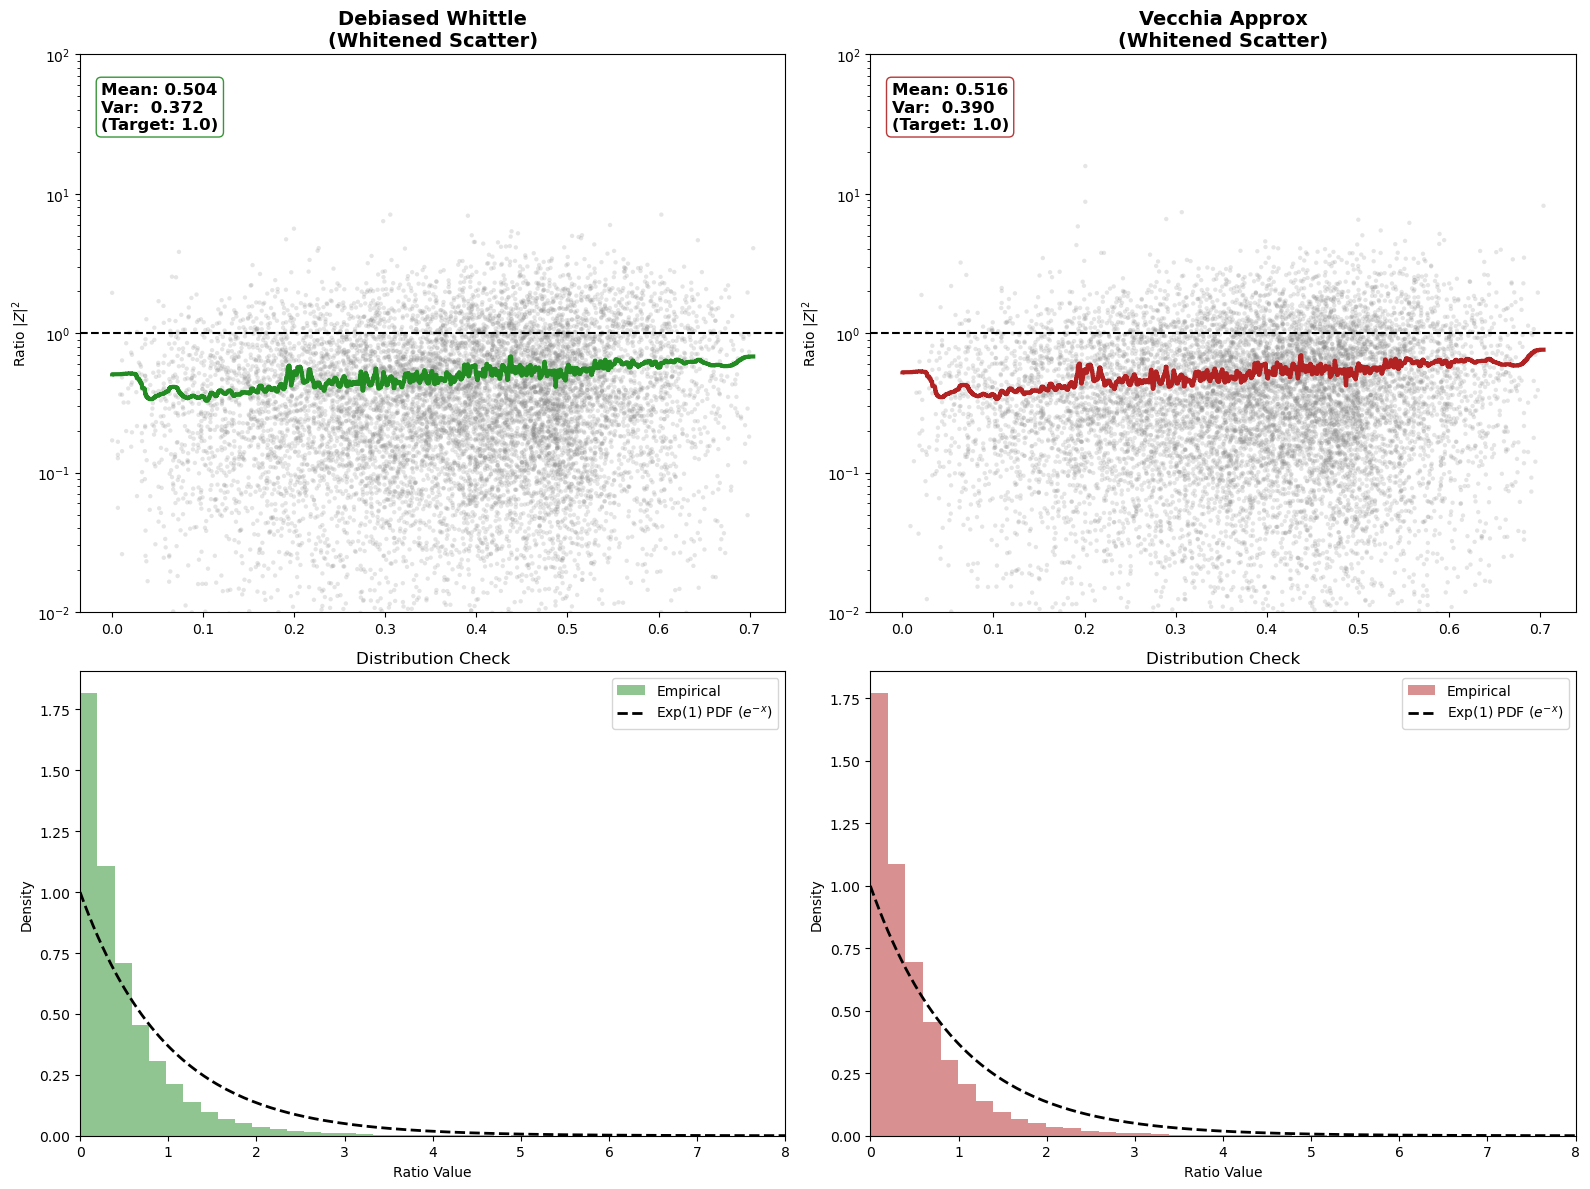

In [65]:
# =========================================================================
# Execution
# =========================================================================
if __name__ == '__main__':
    # 아래 함수를 실행하세요.
    compare_periodogram_diagnostics(
        day_idx=13,  # 0 based index
        dw_df=dw_real_july25,
        #dw_df=vecc_real_july24_feat6,
        vecc_df=vecc_real_july25,
        raw_tensors=daily_aggregated_tensors_dw, 
        raw_maps=daily_hourly_maps_dw
    )


# reference code below

difference data

In [13]:
a = [13.357, 0.1441, 0.1855, 1.1652, 0.0197,-0.1576,0]
day = 1 # 0 index
lat_range= [-3,2]
lon_range= [121, 131]
db = debiased_whittle.debiased_whittle_preprocess(daily_aggregated_tensors_dw, daily_hourly_maps_dw, day_idx=day, params_list=a, lat_range=lat_range, lon_range=lon_range)

subsetted_aggregated_day = db.generate_spatially_filtered_days(-3,2,121,131)
print(subsetted_aggregated_day.shape)
N2= subsetted_aggregated_day.shape[0]
print(N2)
subsetted_aggregated_day

torch.Size([142832, 4])
142832


tensor([[ -2.9720, 121.0460,   0.1927,  45.0000],
        [ -2.9720, 121.1090,   1.4085,  45.0000],
        [ -2.9720, 121.1720,  -2.2274,  45.0000],
        ...,
        [  1.9560, 130.8110,  -4.2944,  52.0000],
        [  1.9560, 130.8740,   3.6669,  52.0000],
        [  1.9560, 130.9370,   5.1847,  52.0000]], dtype=torch.float64)

multivariate

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
import cmath
import sys

# =========================================================================
# 1. The Updated Logic Class (Exactly matching your new requirements)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        """Computes a 2D Hamming window."""
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        hamming1 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        """Computes the normalized taper autocorrelation function c_gn(u) using FFT."""
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        c_gn_grid = autocorr_shifted / (H + 1e-12)
        return c_gn_grid 

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        """Generates J-vector and returns necessary metadata."""
        p_time = len(tensor_list)
        if p_time == 0: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        # Filter valid tensors
        valid_tensors = [t for t in tensor_list if t.numel() > 0 and t.shape[1] > max(lat_col, lon_col, val_col)]
        if not valid_tensors: return torch.empty(0, 0, 0, device=device, dtype=torch.complex128), 0, 0, 0, None

        # Get Coordinates
        all_lats_cpu = torch.cat([t[:, lat_col] for t in valid_tensors]).cpu()
        all_lons_cpu = torch.cat([t[:, lon_col] for t in valid_tensors]).cpu()
        
        # Simple Nan Filter
        mask = ~torch.isnan(all_lats_cpu) & ~torch.isinf(all_lats_cpu) & ~torch.isnan(all_lons_cpu) & ~torch.isinf(all_lons_cpu)
        all_lats_cpu = all_lats_cpu[mask]
        all_lons_cpu = all_lons_cpu[mask]

        unique_lats_cpu, unique_lons_cpu = torch.unique(all_lats_cpu), torch.unique(all_lons_cpu)
        n1, n2 = len(unique_lats_cpu), len(unique_lons_cpu)

        lat_map = {lat.item(): i for i, lat in enumerate(unique_lats_cpu)}
        lon_map = {lon.item(): i for i, lon in enumerate(unique_lons_cpu)}

        # Generate Taper
        u1_mesh_cpu, u2_mesh_cpu = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64),
            torch.arange(n2, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh_cpu, u2_mesh_cpu), n1, n2).to(device)

        # Fill Data Grid
        fft_results = []
        for tensor in tensor_list:
            data_grid = torch.zeros((n1, n2), dtype=torch.float64, device=device)
            tensor_dev = tensor.to(device) # Move data to device
            
            # Note: Vectorized filling is faster, but keeping your loop for safety/robustness
            for row in tensor:
                lat_val, lon_val, val = row[lat_col].item(), row[lon_col].item(), row[val_col].item()
                if not (np.isnan(lat_val) or np.isnan(lon_val) or np.isnan(val)):
                    i = lat_map.get(lat_val)
                    j = lon_map.get(lon_val)
                    if i is not None and j is not None:
                        data_grid[i, j] = val

            data_grid_tapered = data_grid * taper_grid 
            data_grid_tapered = torch.nan_to_num(data_grid_tapered, nan=0.0)
            fft_results.append(torch.fft.fft2(data_grid_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)

        # Norm Factor
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)

        return J_vector_tensor * norm_factor, n1, n2, p_time, taper_grid

    @staticmethod
    def calculate_sample_periodogram_vectorized(J_vector_tensor):
        """Calculates sample periodogram I_n = J J^H."""
        J_col = J_vector_tensor.unsqueeze(-1)
        J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
        return J_col @ J_row_conj

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        """7-Parameter Spatio-Temporal Kernel (Exponential/Matern 0.5)."""
        device = params.device
        
        # Ensure inputs are tensors
        u1 = torch.as_tensor(u1, device=device, dtype=torch.float64)
        u2 = torch.as_tensor(u2, device=device, dtype=torch.float64)
        t  = torch.as_tensor(t, device=device, dtype=torch.float64)

        # Unpack Parameters
        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        epsilon = 1e-12
        sigmasq = phi1 / (phi2 + epsilon)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + epsilon) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + epsilon) * phi2 

        # Advection
        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t

        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + epsilon)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cov_spatial_difference(u1, u2, t, params, delta1, delta2):
        weights = {(0, 0): -2.0, (1, 0): 1.0, (0, 1): 1.0}
        device = params.device
        cov = torch.zeros_like(u1, device=device, dtype=torch.float64)

        for (a, b), w_ab in weights.items():
            for (c, d), w_cd in weights.items():
                lag_u1 = u1 + (a - c) * delta1
                lag_u2 = u2 + (b - d) * delta2
                cov += w_ab * w_cd * debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(lag_u1, lag_u2, t, params)
        return cov

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        # Convert Grid indices to Physical Lags
        lag_u1 = u1 * delta1
        lag_u2 = u2 * delta2
        
        cov_val = debiased_whittle_likelihood.cov_spatial_difference(lag_u1, lag_u2, t, params, delta1, delta2)

        # Get Taper Autocorrelation from Grid
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]

        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        """Calculates expected periodogram using Aliasing Sum (Lemma 2)."""
        device = params.device
        
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, dtype=torch.float64, device=device),
            torch.arange(n2, dtype=torch.float64, device=device),
            indexing='ij'
        )
        t_lags = torch.arange(p_time, dtype=torch.float64, device=device)
        
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                
                # The 4 Aliasing Terms
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        # FFT and Normalize
        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        norm_factor = 1.0 / (4.0 * cmath.pi**2)
        return fft_result * norm_factor
    

Running on: cpu
--- Day 8 Diagnostic Plot (New Multivariate Tapered Logic) ---
Params (Log-Space) on device: tensor([ 4.1756,  1.4771,  0.2173, -3.8969, -0.0299, -0.2392,    -inf],
       dtype=torch.float64)
Generating J-Vector and Taper Grid...


/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_74232/2016658955.py:77: RuntimeWarning: divide by zero encountered in log
  np.log(nugget_val)


Grid: 113x158, Time Points: 8
Calculating Sample Periodogram...
Calculating Taper Autocorrelation...
Calculating Expected Periodogram (Using Aliasing Sum)...

Stats: Mean=1.05, Median=0.97


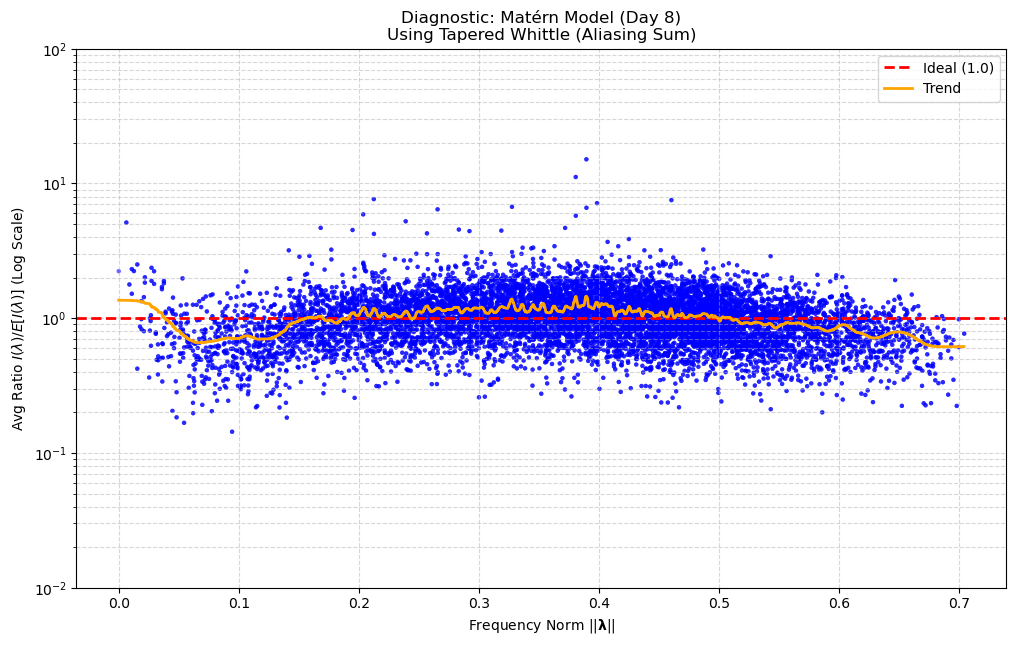

In [15]:


# =========================================================================
# 3. Main Execution Logic for Plotting
# =========================================================================
if __name__ == '__main__':
    # --- Configuration ---
    DAY_TO_RUN = 8
    # Note: Use the Hamming taper from your new class
    TAPERING_FUNC = debiased_whittle_likelihood.cgn_hamming 
    
    # 💥 CRITICAL: Define Deltas corresponding to your grid resolution
    DELTA_LAT = 0.044 
    DELTA_LON = 0.063
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on: {DEVICE}")

    print(f"--- Day {DAY_TO_RUN} Diagnostic Plot (New Multivariate Tapered Logic) ---")
    
    # --- Define Parameters (Must be the 7 physical params) ---
    # Example: [sigma_sq, range_lat, range_lon, range_time, advec_lat, advec_lon, nugget]
    # We must convert these to the LOG parameters required by the kernel
    
    # Physical Values
    sigma_sq_val = 11.81
    range_lat_val = 0.26
    range_lon_val = 0.269
    range_time_val = 1.45
    advec_lat_val = -0.0243
    advec_lon_val = -0.2014
    nugget_val = 0.


    # whittle day 1
    sigma_sq_val = 5.8979
    range_lat_val = 0.1799
    range_lon_val = 0.1867
    range_time_val = 1.0234
    advec_lat_val = -0.0072
    advec_lon_val = 0.0834
    nugget_val = 0.

    # dw day 2
    sigma_sq_val = 12.2788
    range_lat_val = 0.2031
    range_lon_val = 0.23
    range_time_val = 1.508
    advec_lat_val = 0.0043
    advec_lon_val = -0.2981
    nugget_val = 0.


    # vecc day2

    sigma_sq_val = 14.8568
    range_lat_val = 0.2048
    range_lon_val = 0.2283
    range_time_val = 1.6022
    advec_lat_val = -0.0299
    advec_lon_val = -0.2392
    nugget_val = 0.



    # Reparameterization to match kernel expectations:
    # Kernel expects: [log(phi1), log(phi2), log(phi3), log(phi4), advec_lat, advec_lon, log(nugget)]
    phi2 = 1.0 / range_lon_val
    phi1 = sigma_sq_val * phi2
    phi3 = (range_lon_val / range_lat_val)**2
    phi4 = (range_lon_val / range_time_val)**2
    
    best_params_raw = torch.tensor([
        np.log(phi1), 
        np.log(phi2), 
        np.log(phi3), 
        np.log(phi4), 
        advec_lat_val, 
        advec_lon_val, 
        np.log(nugget_val)
    ], device=DEVICE, dtype=torch.float64)

    print(f"Params (Log-Space) on device: {best_params_raw}")

    # --- Data Preparation ---
    # ⚠️ ASSUMING 'subsetted_aggregated_day' IS LOADED IN YOUR ENVIRONMENT
    # If testing standalone, replace this with mock data loading
    try:
        cur_df = subsetted_aggregated_day[DAY_TO_RUN - 1] # Ensure 0-indexed
        cur_df =  subsetted_aggregated_day
        unique_times = torch.unique(cur_df[:, 3])
        tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]
    except NameError:
        print("Error: 'subsetted_aggregated_day' not found. Please load data first.")
        sys.exit(1)

    # --- Step 1: Generate J-Vector & Taper Grid ---
    print("Generating J-Vector and Taper Grid...")
    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, TAPERING_FUNC, lat_col=0, lon_col=1, val_col=2, device=DEVICE
    )
    print(f"Grid: {n1}x{n2}, Time Points: {p_time}")

    # --- Step 2: Sample Periodogram ---
    print("Calculating Sample Periodogram...")
    # J_vec is (n1, n2, p) -> I_sample is (n1, n2, p, p)
    I_sample = debiased_whittle_likelihood.calculate_sample_periodogram_vectorized(J_vec)
    
    # --- Step 3: Taper Autocorrelation (Critical for New Expectation) ---
    print("Calculating Taper Autocorrelation...")
    taper_autocorr_grid = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(
        taper_grid, n1, n2, DEVICE
    )

    # --- Step 4: Expected Periodogram ---
    print("Calculating Expected Periodogram (Using Aliasing Sum)...")
    # Returns (n1, n2, p, p) real tensor
    with torch.no_grad():
        I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
            best_params_raw, n1, n2, p_time, taper_autocorr_grid, DELTA_LAT, DELTA_LON
        )

    # --- Step 5: Plotting Prep (Shift & Diagonal) ---
    # Shift dimensions 0 and 1 (spatial dims). Dims 2 and 3 are time (p x p).
    I_sample_shifted = torch.fft.fftshift(I_sample, dim=(0, 1))
    I_expected_shifted = torch.fft.fftshift(I_expected, dim=(0, 1))

    # We take the diagonal of the p x p time matrix (auto-spectra at each spatial freq)
    # Result is (n1, n2, p)
    diag_sample = torch.diagonal(I_sample_shifted, dim1=-2, dim2=-1).real
    diag_expected = torch.diagonal(I_expected_shifted, dim1=-2, dim2=-1) # Already real

    epsilon = 1e-15
    ratio_grid = diag_sample / (diag_expected + epsilon)
    
    # Average over time steps (optional, or plot specific time step)
    ratio_magnitude_avg = torch.mean(ratio_grid, dim=-1).cpu().numpy()

    # --- Step 6: Visualization ---
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    freq_lon_shifted, freq_lat_shifted = fftshift(freq_lon), fftshift(freq_lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon_shifted, freq_lat_shifted)
    frequency_norm = np.sqrt(freq_grid_lat**2 + freq_grid_lon**2)
    
    norm_flat = frequency_norm.flatten()
    ratio_flat = ratio_magnitude_avg.flatten()

    plt.figure(figsize=(12, 7))
    plt.scatter(norm_flat, ratio_flat, s=10, alpha=0.6, c='blue', edgecolors='none')
    plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal (1.0)')
    
    # Add smoothing trend line (optional)
    try:
        from scipy.ndimage import gaussian_filter1d
        sorted_indices = np.argsort(norm_flat)
        plt.plot(norm_flat[sorted_indices], 
                 gaussian_filter1d(ratio_flat[sorted_indices], sigma=50), 
                 color='orange', linewidth=2, label='Trend')
    except ImportError:
        pass

    plt.yscale('log')
    plt.ylim(1e-2, 1e2)
    plt.title(f'Diagnostic: Matérn Model (Day {DAY_TO_RUN})\nUsing Tapered Whittle (Aliasing Sum)')
    plt.xlabel(r'Frequency Norm $||\boldsymbol{\lambda}||$')
    plt.ylabel(r'Avg Ratio $I(\lambda) / E[I(\lambda)]$ (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    print(f"\nStats: Mean={np.mean(ratio_flat):.2f}, Median={np.median(ratio_flat):.2f}")
    plt.show()

univariate

--- Day 1 Diagnostic Plot for Matérn (nu=0.5) ---
Using parameters: [13.06, 0.154, 0.195, 1.0, 0.0218, -0.1689, 0.247]
Data grid: 113x158 spatial points, 8 time points.

Stats: Mean=0.85


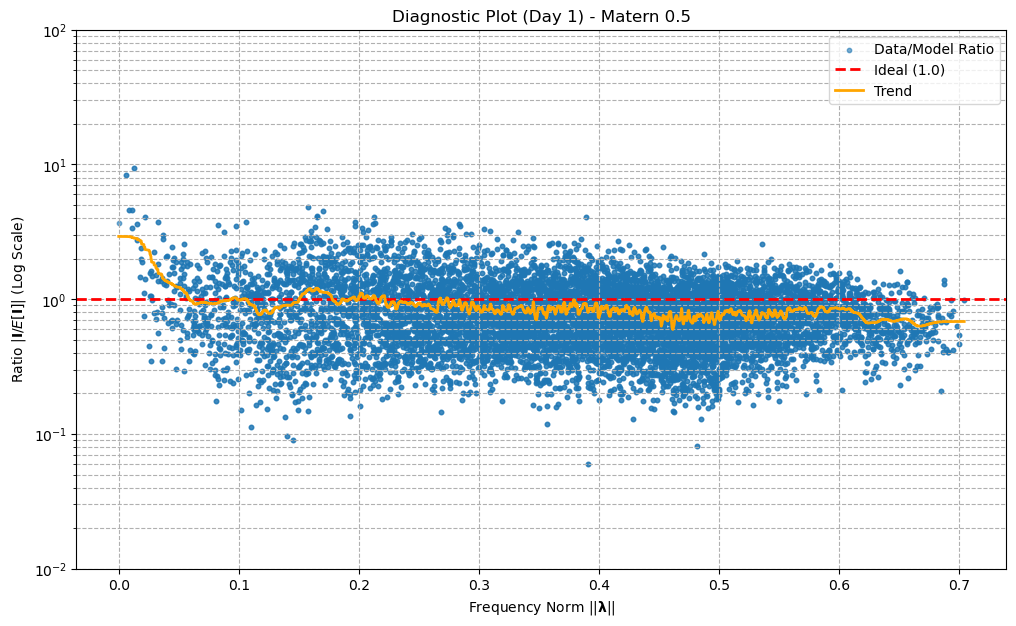

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
import cmath
import sys

# =========================================================================
# 1. Tapering and Modeling Functions
# =========================================================================

def cgn_hamming(u, n1, n2):
    """Computes a 2D Hamming window."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1_tensor / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2_tensor / n2)
    return hamming1 * hamming2

def cgn_2dbartlett(u, n1, n2):
    """Computes a 2D Bartlett window function (triangular window)."""
    u1, u2 = u
    return (1 - torch.abs(u1) / n1) * (1 - torch.abs(u2) / n2) 

def cov_x(u1, u2, t, params, nu=0.5):
    """
    Covariance function for PLOTTING using the Matérn model (nu=0.5 / Exponential).
    It expects parameters in their PHYSICAL (Natural) space.
    """
    # Unpack the 7 parameters (Order must match your optimization output)
    # [sigma_sq, range_lat, range_lon, range_time, advec_lat, advec_lon, nugget]
    sigmasq   = params[0]
    range_lat = params[1]
    range_lon = params[2]
    range_time= params[3]
    advec_lat = params[4]
    advec_lon = params[5]
    nugget    = params[6]
    
    # Advection Logic
    u1_adv = u1 - advec_lat * t
    u2_adv = u2 - advec_lon * t
    
    # Distance Calculation (Standardized by ranges)
    # Note: range_time is used here. If you use beta, replace (t/range_time) with (t*beta)
    distance_sq = (u1_adv / range_lat)**2 + (u2_adv / range_lon)**2 + (t / range_time)**2
    distance = torch.sqrt(distance_sq + 1e-12)
    
    # --- 💥 CHANGE: Exponential Kernel (Nu=0.5) ---
    # Formula: sigma^2 * exp(-d)
    matern_cov = sigmasq * torch.exp(-distance)
    
    # Add Nugget at lag 0
    # Note: If distance is ~0, covariance is sigma^2 + nugget
    return torch.where(distance_sq > 1e-9, matern_cov, sigmasq + nugget)

def cov_first_difference(u1, u2, t, params, nu):
    """Computes the autocovariance of the first-difference-filtered process."""
    
    # 💥 CRITICAL: Use your specific grid resolution
    delta1, delta2 = 0.044, 0.063
    
    # Weights for spatial first difference
    stencil_weights = {(0, 0): -2, (1, 0): 1, (0, 1): 1}
    
    cov = torch.zeros_like(u1, dtype=torch.float32)
    
    for (a, b), w_ab in stencil_weights.items():
        for (c, d), w_cd in stencil_weights.items():
            # Apply resolution scaling to lags
            offset_x = (a - c) * delta1
            offset_y = (b - d) * delta2
            
            lag_x = u1 + offset_x
            lag_y = u2 + offset_y
            
            cov += w_ab * w_cd * cov_x(lag_x, lag_y, t, params, nu)
    return cov

def cn_bar(u1, u2, t, params, n1, n2, taper_func, nu):
    """Computes the tapered covariance for the filtered field."""
    u = (u1, u2)
    # Note: u1, u2 here are PHYSICAL lags (already scaled by delta in expected_periodogram)
    # OR they are indices. In this script, 'expected_periodogram' passes INDICES.
    # So 'cov_first_difference' must handle the scaling. 
    # Current setup: cov_first_difference applies deltas to the OFFSETS, 
    # but assumes u1, u2 are already physical.
    # Let's fix this in the main loop below.
    return cov_first_difference(u1, u2, t, params, nu) * taper_func(u, n1, n2)

def expected_periodogram_fft_multivariate(params, n1, n2, p, taper_func, nu, delta1=0.044, delta2=0.063):
    """Calculates the expected periodogram for the FILTERED field."""
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    t_lags = torch.arange(p, dtype=torch.float32)
    
    # Create Index Mesh
    u1_idx, u2_idx = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')

    # Convert Indices to Physical Distances for the covariance function
    u1_phys = u1_idx * delta1
    u2_phys = u2_idx * delta2

    for q in range(p):
        for r in range(p):
            t = t_lags[q] - t_lags[r]
            # Pass Physical Lags to covariance, but Grid Indices to Taper
            cov_val = cov_first_difference(u1_phys, u2_phys, t, params, nu)
            taper_val = taper_func((u1_idx, u2_idx), n1, n2)
            
            product_tensor[:, :, q, r] = cov_val * taper_val

    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    normalization_factor = 1 / (2 * cmath.pi)**2
    return fft_result * normalization_factor

# =========================================================================
# 2. Data Processing Functions
# =========================================================================
def generate_Jvector_final(tensor_list, taper_func, lat_col=0, lon_col=1, val_col=2):
    p = len(tensor_list)
    if p == 0:
        return torch.empty(0, 0, 0), 0, 0, 0

    all_lats = torch.cat([t[:, lat_col] for t in tensor_list])
    all_lons = torch.cat([t[:, lon_col] for t in tensor_list])
    unique_lats, unique_lons = torch.unique(all_lats), torch.unique(all_lons)
    n1, n2 = len(unique_lats), len(unique_lons)

    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}

    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    taper_grid = taper_func((u1_mesh, u2_mesh), n1, n2)

    fft_results = []
    for tensor in tensor_list:
        data_grid = torch.zeros((n1, n2), dtype=torch.float32)
        for row in tensor:
             i = lat_map[row[lat_col].item()]
             j = lon_map[row[lon_col].item()]
             data_grid[i, j] = row[val_col]
        
        data_grid_tapered = data_grid * taper_grid
        fft_results.append(torch.fft.fft2(data_grid_tapered))

    J_vector_tensor = torch.stack(fft_results, dim=2)

    H = torch.sum(taper_grid**2)
    norm_factor = torch.sqrt(1 / H) / (2 * cmath.pi)
    
    return J_vector_tensor * norm_factor, n1, n2, p

def calculate_sample_periodogram_vectorized(J_vector_tensor):
    """Efficient vectorized version."""
    J_col = J_vector_tensor.unsqueeze(-1)
    J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
    return J_col @ J_row_conj

# =========================================================================
# 3. Main Execution Logic
# =========================================================================
if __name__ == '__main__':
    # --- Configuration ---
    DAY_TO_RUN = 1
    TAMPERING_FUNC = cgn_2dbartlett # Or switch to cgn_hamming
    NU_SMOOTHNESS = 0.5 
    
    print(f"--- Day {DAY_TO_RUN} Diagnostic Plot for Matérn (nu={NU_SMOOTHNESS}) ---")
    
    # --- Params (Physical Space) ---
    # [sigma_sq, range_lat, range_lon, range_time, advec_lat, advec_lon, nugget]
    # Update these with your fit_vecchia_lbfgs output
    best_params = [13.06, 0.154, 0.195, 1.0, 0.0218, -0.1689, 0.247] 
    
    print(f"Using parameters: {best_params}")
    
    # --- Data Loading (Placeholder: Ensure subsetted_aggregated_day is available) ---
    try:
        cur_df = subsetted_aggregated_day[DAY_TO_RUN - 1]
        cur_df = subsetted_aggregated_day
        unique_times = torch.unique(cur_df[:, 3])
        tensor_list = [cur_df[cur_df[:, 3] == t_val] for t_val in unique_times]
    except NameError:
        print("Error: 'subsetted_aggregated_day' variable not found. Please load your data.")
        sys.exit(1)
    
    # --- Calculation ---
    J_vec, n1, n2, p = generate_Jvector_final(tensor_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=2)
    print(f"Data grid: {n1}x{n2} spatial points, {p} time points.")
    
    I_sample = calculate_sample_periodogram_vectorized(J_vec)
    
    # Pass Deltas Explicitly here
    I_expected = expected_periodogram_fft_multivariate(
        best_params, n1, n2, p, TAMPERING_FUNC, 
        nu=NU_SMOOTHNESS, delta1=0.044, delta2=0.063
    )

    # Shift for plotting
    I_sample_shifted = torch.fft.fftshift(I_sample, dim=(-4, -3))
    I_expected_shifted = torch.fft.fftshift(I_expected, dim=(-4, -3))
    
    # Diagonal ratio
    epsilon = 1e-15
    ratio_complex = I_sample_shifted / (I_expected_shifted + epsilon)
    diagonal_ratio = torch.diagonal(ratio_complex, dim1=-2, dim2=-1) 
    ratio_magnitude_avg = torch.mean(torch.abs(diagonal_ratio), dim=-1)
    
    # --- Plotting ---
    freq_lat = np.fft.fftfreq(n1)
    freq_lon = np.fft.fftfreq(n2)
    freq_lon_shifted, freq_lat_shifted = fftshift(freq_lon), fftshift(freq_lat)
    freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon_shifted, freq_lat_shifted)
    frequency_norm = np.sqrt(freq_grid_lat**2 + freq_grid_lon**2)
    
    norm_flat = frequency_norm.flatten()
    ratio_flat = ratio_magnitude_avg.detach().numpy().flatten()

    plt.figure(figsize=(12, 7))
    plt.scatter(norm_flat, ratio_flat, s=10, alpha=0.6, label='Data/Model Ratio')
    plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal (1.0)')
    
    # Add trend line
    from scipy.ndimage import gaussian_filter1d
    sorted_idx = np.argsort(norm_flat)
    plt.plot(norm_flat[sorted_idx], gaussian_filter1d(ratio_flat[sorted_idx], sigma=30), 
             color='orange', linewidth=2, label='Trend')

    plt.yscale('log')
    plt.ylim(1e-2, 1e2)
    plt.title(f'Diagnostic Plot (Day {DAY_TO_RUN}) - Matern 0.5')
    plt.xlabel(r'Frequency Norm $||\boldsymbol{\lambda}||$')
    plt.ylabel(r'Ratio $|\mathbf{I} / E[\mathbf{I}]|$ (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    print(f"\nStats: Mean={np.mean(ratio_flat):.2f}")
    plt.show()